<a href="https://colab.research.google.com/github/elizabethiva/Machine_Learning_Portfolio/blob/main/Shakespearean_Sonnet_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shakespearean Sonnet Generation

This model predicts the next word in a text sequence, using a corpus of Shakespeare's sonnets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

For this project  it is necessary to download the [Shakespeare Sonnets Dataset](https://www.opensourceshakespeare.org/views/sonnets/sonnet_view.php?range=viewrange&sonnetrange1=1&sonnetrange2=154), which contains more than 2000 lines of text extracted from Shakespeare's sonnets.

In [2]:
# sonnets.txt
!gdown --id 108jAePKK4R3BVYBbYJZ32JWUwxeMg20K

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K
To: /content/sonnets.txt
100% 93.6k/93.6k [00:00<00:00, 123MB/s]


In [3]:
# Define path for file with sonnets
SONNETS_FILE = './sonnets.txt'

# Read the data
with open('./sonnets.txt') as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

There are 2159 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


## Tokenizing the text

Now fit the Tokenizer to the corpus and save the total number of words.

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

## Generating n_grams

This function receives the fitted tokenizer and the corpus (which is a list of strings) and should return a list containing the `n_gram` sequences for each line in the corpus:

In [5]:
def n_gram_seqs(corpus, tokenizer):
    """
    Generates a list of n-gram sequences

    Args:
        corpus (list of string): lines of texts to generate n-grams for
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary

    Returns:
        input_sequences (list of int): the n-gram sequences for each line in the corpus
    """
    input_sequences = []

    for line in corpus:
      token_list = tokenizer.texts_to_sequences([line])[0]
      for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

    return input_sequences

Apply the `n_gram_seqs` transformation to the whole corpus and save the maximum sequence length to use it later:

In [8]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

# Save max length
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 15462
maximum length of sequences is: 11


## Add padding to the sequences

The `pad_seqs` function will pad any given sequences to the desired maximum length:

In [9]:
def pad_seqs(input_sequences, maxlen):
    """
    Pads tokenized sequences to the same length

    Args:
        input_sequences (list of int): tokenized sequences to pad
        maxlen (int): maximum length of the token sequences

    Returns:
        padded_sequences (array of int): tokenized sequences padded to the same length
    """
    padded_sequences = pad_sequences(input_sequences, maxlen=maxlen)

    return padded_sequences

In [12]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15462, 11)


## Split the data into features and labels

The `features_and_labels` function expects the padded n_gram sequences as input and return a tuple containing the features and the one hot encoded labels.


In [13]:
def features_and_labels(input_sequences, total_words):
    """
    Generates features and labels from n-grams

    Args:
        input_sequences (list of int): sequences to split features and labels from
        total_words (int): vocabulary size

    Returns:
        features, one_hot_labels (array of int, array of int): arrays of features and one-hot encoded labels
    """
    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels = to_categorical(labels, num_classes=total_words)

    return features, one_hot_labels

In [15]:
# Split the whole corpus
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (15462, 10)
labels have shape: (15462, 3211)


## Create the model

The `create_model` function define a model architecture capable of achieving an accuracy of 84%.


In [16]:
def create_model(total_words, max_sequence_len):
    """
    Creates a text generator model

    Args:
        total_words (int): size of the vocabulary for the Embedding layer input
        max_sequence_len (int): length of the input sequences

    Returns:
        model (tf.keras Model): the text generator model
    """
    model = Sequential()
    model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
    model.add(Bidirectional(LSTM(150)))
    model.add(Dense(total_words, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [17]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)

# Train the model
history = model.fit(features, labels, epochs=50, verbose=1)

Epoch 1/50
484/484 [==============================] - 25s 29ms/step - loss: 6.8770 - accuracy: 0.0222
Epoch 2/50
484/484 [==============================] - 4s 9ms/step - loss: 6.4274 - accuracy: 0.0327
Epoch 3/50
484/484 [==============================] - 4s 8ms/step - loss: 6.1756 - accuracy: 0.0413
Epoch 4/50
484/484 [==============================] - 5s 9ms/step - loss: 5.8876 - accuracy: 0.0526
Epoch 5/50
484/484 [==============================] - 4s 8ms/step - loss: 5.5622 - accuracy: 0.0660
Epoch 6/50
484/484 [==============================] - 4s 8ms/step - loss: 5.1953 - accuracy: 0.0794
Epoch 7/50
484/484 [==============================] - 4s 9ms/step - loss: 4.7892 - accuracy: 0.1026
Epoch 8/50
484/484 [==============================] - 4s 7ms/step - loss: 4.3673 - accuracy: 0.1387
Epoch 9/50
484/484 [==============================] - 4s 7ms/step - loss: 3.9393 - accuracy: 0.1929
Epoch 10/50
484/484 [==============================] - 5s 10ms/step - loss: 3.5367 - accuracy: 0.2

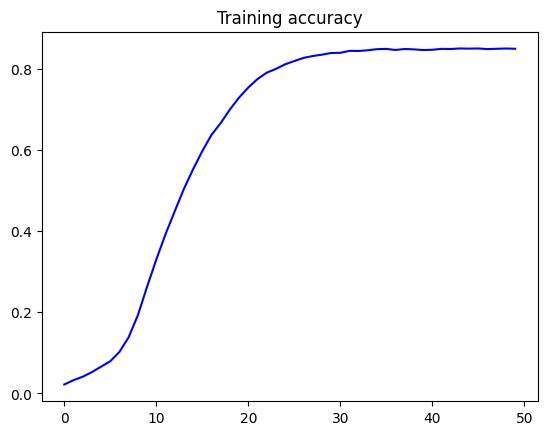

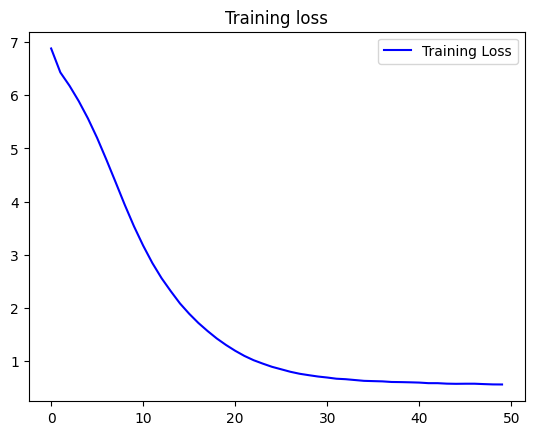

In [18]:
# Take a look at the training curves of the model

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

## Generate sonnets in the style of William Shakespeare.



In [26]:
seed_text = "So let us grasp each moment, hold it tight, And let our love shine on through day and night."
next_words = 55

for _ in range(next_words):
    # Convert the text into sequences
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    # Pad the sequences
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    # Get the probabilities of predicting a word
    predicted = model.predict(token_list, verbose=0)
    # Choose the next word based on the maximum probability
    predicted = np.argmax(predicted, axis=-1).item()
    # Get the actual word from the word index
    output_word = tokenizer.index_word[predicted]
    # Append to the current text
    seed_text += " " + output_word

print(seed_text)

So let us grasp each moment, hold it tight, And let our love shine on through day and night. oppress'd to thee doth lie with thee is back more rare with me tell the time care to say so strong fair friend ' knows me so alone with thee is but with those muse thou fill ' prove the time bettering bare aside bright her truth as bright in any shall age with me
